# **Exploration of Preprocessing**

---

In [5]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

sys.path.append('..')
from preprocessing.preprocessing_functions import make_sequence_df, reindex_frames

In [2]:
df_data = pd.read_csv('../asl-signs/train.csv')
subset_signs = ['cry', 'blow', 'shhh']
path = Path('../asl-signs')

df = make_sequence_df(path = path, df_data = df_data, sign_list = subset_signs)
display(df.head(3))

,frame,row_id,type,landmark_index,x,y,z,participant_id,sequence_id,sign
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626,26734,1000035562,blow
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565,26734,1000035562,blow
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283,26734,1000035562,blow


## **Centering around Nose**

- Since one of the keypoint normalization methods will be centering around nose, those specific landmarks cannot be NaN values
- Center of the nose is 4th landmark index of the face category


<img src="../landmark_visualization/face.png" width="400" height="300">



In [3]:
nose_data = df[(df['type'] == 'face') & (df['landmark_index'] == 4)]

# ~~~ missing nose cordinates

nose_missing = nose_data[["x", "y", "z"]].isnull().sum()
print("Missing nose cords:")
print(nose_missing)


# ~~~ Sequences with missing nose frames
nose_missing_data = nose_data[nose_data['x'].isnull()]
print("Sequences with missing nose: ", nose_missing_data['sequence_id'].nunique())

# ~~~ Compare
sequence_frames_missing_nose_missing_frames = nose_missing_data.groupby('sequence_id')['frame'].nunique()
sequence_frames_missing_nose_total_frames = df[df['sequence_id'].isin(sequence_frames_missing_nose_missing_frames.index)].groupby('sequence_id')['frame'].nunique()

comparison = pd.DataFrame({
    'missing_frames': sequence_frames_missing_nose_missing_frames,
    'total_frames': sequence_frames_missing_nose_total_frames,
    'percent_missing' : (sequence_frames_missing_nose_missing_frames / sequence_frames_missing_nose_total_frames) * 100
})
comparison = comparison.sort_values('percent_missing', ascending=False)
display(comparison)

print(comparison['percent_missing'].describe())

Missing nose cords:
x    994
y    994
z    994
dtype: int64
Sequences with missing nose:  102


,missing_frames,total_frames,percent_missing
sequence_id,,,
2725590426,3,3,100.000000
2715399088,16,17,94.117647
887157068,9,10,90.000000
1363776467,8,9,88.888889
3994650036,6,7,85.714286
...,...,...,...
173905394,3,199,1.507538
2473220537,1,84,1.190476
3610096849,1,94,1.063830


count    102.000000
mean      25.242152
std       25.173052
min        0.401606
25%        7.238863
50%       15.610665
75%       35.182709
max      100.000000
Name: percent_missing, dtype: float64


**Takeaways**:

- Nose cordinates are always missing together
- There is quite a number of sequences missing some nose cordinates throughout the frames
- Majority of the sequences are only missing around 35% of nose frames

**To do**:

- Fill the missing nose cordinates by:
    - Interpolating where possible
    - when interpolation not possible just filling with the last valid value forward, and backwards

- Sequences missing 100% of their nose landmarks should be dropped for sure
- I'll be exploring how many sequences would be lost when dropping the sequences with for example missing nose over 50%, 75% of frames etc or if its worth it at all

## **Missing LandMarks**

- Exploring all of the missing landmarks not just the nose

In [4]:
total_by_landmark = df.groupby(['type', 'landmark_index']).size()
missing_by_landmark = df[df['x'].isnull()].groupby(['type', 'landmark_index']).size()


comparison = pd.DataFrame({
    'total': total_by_landmark,
    'missing': missing_by_landmark,
    'percent_missing' : ((missing_by_landmark / total_by_landmark) * 100).round(2)
}).fillna(0)

comparison = comparison.sort_values(['type', 'landmark_index'], ascending=True)

#with pd.option_context('display.max_rows', None):
#    display(comparison)
display(comparison)

total  missing  percent_missing
type       landmark_index                                 
face       0               46102    994.0             2.16
           1               46102    994.0             2.16
           2               46102    994.0             2.16
           3               46102    994.0             2.16
           4               46102    994.0             2.16
...                          ...      ...              ...
right_hand 16              46102  29884.0            64.82
           17              46102  29884.0            64.82
           18              46102  29884.0            64.82
           19              46102  29884.0            64.82
           20              46102  29884.0            64.82

[543 rows x 3 columns]

**Takeaway**:

- Missing are values always 'missing together' so when the nose landmark with id = 4 is missing, the whole face is missing
- Missing:
    - Face landmarks 2% of the time
    - Pose seems to be never Missing
    - Hands are missing a lot, not sure if they are key parts of the recognized sign or not

- Interpolation, filling -> whole face not just the nose
- Pose seems fine, but need more proof its never missing
- Hands fill be interpolated, filled probably

**What about the whole dataset?**

**Takeaway (from the cell below)**:

- mostly same results as above
- pose really doesnt miss anywhere which is good for torso scaling or shoulder scaling

In [5]:
all_totals = []
all_missing = []

for idx, row in df_data.iterrows():
    df = pd.read_parquet(path / row['path'])
    
    total = df.groupby(['type', 'landmark_index']).size()
    missing = df[df['x'].isnull()].groupby(['type', 'landmark_index']).size()
    
    all_totals.append(total)
    all_missing.append(missing)

# Combine all sequences
total_by_landmark = pd.concat(all_totals).groupby(['type', 'landmark_index']).sum()
missing_by_landmark = pd.concat(all_missing).groupby(['type', 'landmark_index']).sum()

# Create comparison
comparison = pd.DataFrame({
    'total': total_by_landmark,
    'missing': missing_by_landmark,
    'percent_missing': ((missing_by_landmark / total_by_landmark) * 100).round(2)
}).fillna(0)

comparison = comparison.sort_values(['type', 'landmark_index'], ascending=True)

with pd.option_context('display.max_rows', None):
    display(comparison)

total    missing  percent_missing
type       landmark_index                                     
face       0               3583987    24322.0             0.68
           1               3583987    24322.0             0.68
           2               3583987    24322.0             0.68
           3               3583987    24322.0             0.68
           4               3583987    24322.0             0.68
           5               3583987    24322.0             0.68
           6               3583987    24322.0             0.68
           7               3583987    24322.0             0.68
           8               3583987    24322.0             0.68
           9               3583987    24322.0             0.68
           10              3583987    24322.0             0.68
           11              3583987    24322.0             0.68
           12              3583987    24322.0             0.68
           13              3583987    24322.0             0.68
           14              3583987    24322.0             0.68
           15              3583987    24322.0             0.68
           16              3583987    24322.0             0.68
           17              3583987    24322.0             0.68
           18              3583987    24322.0             0.68
           19              3583987    24322.0             0.68
           20              3583987    24322.0             0.68
           21              3583987    24322.0             0.68
           22              3583987    24322.0             0.68
           23              3583987    24322.0             0.68
           24              3583987    24322.0             0.68
           25              3583987    24322.0             0.68
           26              3583987    24322.0             0.68
           27              3583987    24322.0             0.68
           28              3583987    24322.0             0.68
           29              3583987    24322.0             0.68
           30              3583987    24322.0             0.68
           31              3583987    24322.0             0.68
           32              3583987    24322.0             0.68
           33              3583987    24322.0             0.68
           34              3583987    24322.0             0.68
           35              3583987    24322.0             0.68
           36              3583987    24322.0             0.68
           37              3583987    24322.0             0.68
           38              3583987    24322.0             0.68
           39              3583987    24322.0             0.68
           40              3583987    24322.0             0.68
           41              3583987    24322.0             0.68
           42              3583987    24322.0             0.68
           43              3583987    24322.0             0.68
           44              3583987    24322.0             0.68
           45              3583987    24322.0             0.68
           46              3583987    24322.0             0.68
           47              3583987    24322.0             0.68
           48              3583987    24322.0             0.68
           49              3583987    24322.0             0.68
           50              3583987    24322.0             0.68
           51              3583987    24322.0             0.68
           52              3583987    24322.0             0.68
           53              3583987    24322.0             0.68
           54              3583987    24322.0             0.68
           55              3583987    24322.0             0.68
           56              3583987    24322.0             0.68
           57              3583987    24322.0             0.68
           58              3583987    24322.0             0.68
           59              3583987    24322.0             0.68
           60              3583987    24322.0             0.68
           61              3583987    24322.0             0.

## **Scaling By Shoulder Width**

- As seen above no need to fill pose landmark values because its never NaN, can just scale with it
- By the image below, the 12th and the 11th landmark index are the shoulders in the pose category

<img src="../landmark_visualization/pose.png" width="600" height="300">

## **What to do with hands**

In [6]:
df = make_sequence_df(path = path, df_data = df_data, sign_list = subset_signs)
display(df.head(3))

,frame,row_id,type,landmark_index,x,y,z,participant_id,sequence_id,sign
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626,26734,1000035562,blow
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565,26734,1000035562,blow
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283,26734,1000035562,blow


In [7]:
left_hand_data = df[(df['type'] == 'left_hand')]


# ~~~ missing hand cordinates
left_hand_missing = left_hand_data[["x", "y", "z"]].isnull().sum()
print("Missing left hand:")
print(left_hand_missing)

# ~~~ Sequences with missing hand frames
left_hand_missing_data = left_hand_data[left_hand_data['x'].isnull()]
print("Sequences with missing nose: ", left_hand_missing_data['sequence_id'].nunique())

# ~~~ Compare
sequence_frames_missing_lefthand_missing_frames = left_hand_missing_data.groupby('sequence_id')['frame'].nunique()
sequence_frames_missing_lefthand_total_frames = df[df['sequence_id'].isin(sequence_frames_missing_lefthand_missing_frames.index)].groupby('sequence_id')['frame'].nunique()

comparison = pd.DataFrame({
    'missing_frames': sequence_frames_missing_lefthand_missing_frames,
    'total_frames': sequence_frames_missing_lefthand_total_frames,
    'percent_missing' : (sequence_frames_missing_lefthand_missing_frames / sequence_frames_missing_lefthand_total_frames) * 100
})
comparison = comparison.sort_values('percent_missing', ascending=False)
display(comparison)

print(comparison['percent_missing'].describe())

Missing left hand:
x    624981
y    624981
z    624981
dtype: int64
Sequences with missing nose:  1045


,missing_frames,total_frames,percent_missing
sequence_id,,,
4293583116,11,11,100.000000
4284322802,19,19,100.000000
9763903,11,11,100.000000
11814611,11,11,100.000000
13828063,15,15,100.000000
...,...,...,...
2303345129,1,75,1.333333
3267389917,1,76,1.315789
2256141134,1,77,1.298701


count    1045.000000
mean       78.106450
std        33.743063
min         0.735294
25%        53.763441
50%       100.000000
75%       100.000000
max       100.000000
Name: percent_missing, dtype: float64


**Takeaway**:

- Hand landmarks are missing quite a lot
- Two possibilities:
    1) Fill everything with 0
    2) If even 1 frame contains landmark values, interpolate + bfill + ffill and only fill sequences with 0s where the hand is not present at all
- around 50% of the time the hand is missing completely, but other times its sometimes captured
    

## **Dropping**

- Sequences with entire ***face*** landmarks missing on every frame because cant center around NaN
- Potentially the sequences which are missing more than > x % of face landmarks 
    - 50?, 75? 99? 

In [8]:
face_data = df[df['type'] == 'face']

missing_frames_per_seq = face_data[face_data['x'].isnull()].groupby('sequence_id')['frame'].nunique()
total_frames_per_seq = face_data.groupby('sequence_id')['frame'].nunique()

comparison = pd.DataFrame({
    'missing': missing_frames_per_seq,
    'total': total_frames_per_seq,
    'percent_missing' : (missing_frames_per_seq / total_frames_per_seq) * 100
}).fillna(0)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 50%
threshholds = [50,75,99]
for threshold in threshholds:
    bad_sequences = comparison[comparison['percent_missing'] > threshold]

    print('Threshold %: ', threshold)
    print('Total sequences: ', df['sequence_id'].nunique())
    print('Sequences with x % missing nose: ', len(bad_sequences))
    print('Percentage to drop: ', len(bad_sequences) / df['sequence_id'].nunique() * 100)


Threshold %:  50
Total sequences:  1192
Sequences with x % missing nose:  15
Percentage to drop:  1.2583892617449663
Threshold %:  75
Total sequences:  1192
Sequences with x % missing nose:  9
Percentage to drop:  0.7550335570469799
Threshold %:  99
Total sequences:  1192
Sequences with x % missing nose:  1
Percentage to drop:  0.08389261744966443


**Takeaway**:

- Even if unreliable sequences with more than 50% of face landmarks missing are dropped, its only 1% of the dataset being lost

In [10]:
from tqdm import tqdm

threshold = 0.5
bad_sequence_ids = []
    
for index, row in tqdm(df_data.iterrows(), total=len(df_data), desc="Checking sequences"):
    df = pd.read_parquet(path / row['path'])
    
    face_data = df[df['type'] == 'face']

    missing_frames = face_data[face_data['x'].isnull()]['frame'].nunique()
    total_frames = face_data['frame'].nunique()
    
    percent_missing = missing_frames / total_frames
    if percent_missing >= threshold:
        bad_sequence_ids.append(row['sequence_id'])

print(f'\nSequences before: {len(df_data)}')
print(f'Dropping: {len(bad_sequence_ids)} sequences (>{threshold*100}% missing face)')

clean_metadata = df_data[~df_data['sequence_id'].isin(bad_sequence_ids)].reset_index(drop=True)

print(f'Sequences after: {len(clean_metadata)}')

Checking sequences: 100%|██████████| 94477/94477 [20:12<00:00, 77.93it/s] 


Sequences before: 94477
Dropping: 343 sequences (>50.0% missing face)
Sequences after: 94134


**Takeaway**:

- In the whole dataset, would 50% threshhold would only drop around 0.4% of the sequences

## **Resample dataset**

- Take this sequence: 7 frames

- Take the whole dataset and divide it in groups:
    - type, landmark -> face 0, face 1, ...
- Each group 7 rows of data

- old indices: [0,1,2,3,4,5,6]
- what I want the indices to be: [0,1,2,...,59]
- Create smooth function with CubicSpline:
    x = old indices
    y = the x/y/z values of the indices

- need to sample from the function 60 times - evenly distributed
- linspace -> [0., 0.10169492, 0.20338983, ... 6]
- evaluate the function created earlier on these new x values -> get y from them

Frame count of the sequence: 7
Old frame indices of the sequence:
 [0 1 2 3 4 5 6]
What I want to be the new frame indices of the sequence:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]

 The values I have now for the frame indices of x:
 [0.43825069 0.43752682 0.44016373 0.44362301 0.44478661 0.44780159
 0.45045519]
Where the function needs to be evaluated (x) cords: 
 [0.         0.10169492 0.20338983 0.30508475 0.40677966 0.50847458
 0.61016949 0.71186441 0.81355932 0.91525424 1.01694915 1.11864407
 1.22033898 1.3220339  1.42372881 1.52542373 1.62711864 1.72881356
 1.83050847 1.93220339 2.03389831 2.13559322 2.23728814 2.33898305
 2.44067797 2.54237288 2.6440678  2.74576271 2.84745763 2.94915254
 3.05084746 3.15254237 3.25423729 3.3559322  3.45762712 3.55932203
 3.66101695 3.76271186 3.86440678 3.96610169 4.06779661 4.16949153
 4.27118644 4.37288

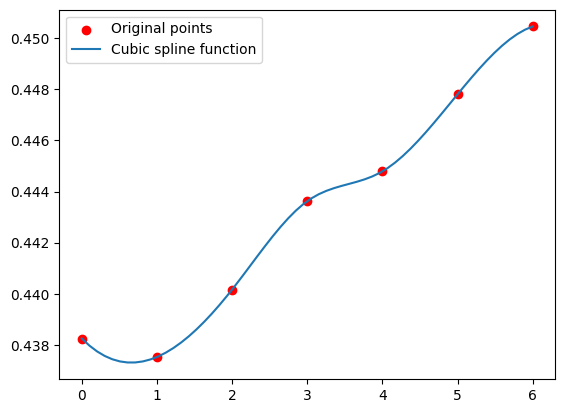

In [ ]:

df = pd.read_parquet('../asl-signs/train_landmark_files/2044/635217.parquet')
df = reindex_frames(df)

# setup
frames = df['frame'].nunique()
print(f'Frame count of the sequence: {frames}')
old_frame_indices = np.arange(df['frame'].nunique())
print(f'Old frame indices of the sequence:\n {old_frame_indices}')
new_frame_indices = np.arange(60)
print(f'What I want to be the new frame indices of the sequence:\n {new_frame_indices}')

# just getting a random group to work with
groups = df.groupby(['type', 'landmark_index'])
face_0 = groups.get_group(('face', 0))
y_values = face_0['x'].values
print(f'\n The values I have now for the frame indices of x:\n {y_values}')

# function setup with 7 indices and what the values are there
cubicsplinex = CubicSpline(old_frame_indices, y_values)
plt.scatter(old_frame_indices, face_0['x'].values, color="red", marker="o", label="Original points")

# interpolation points, evaluating the original function at those 60 new points
new_interpolation_points = np.linspace(0, frames - 1, num = 60)
print(f'Where the function needs to be evaluated (x) cords: \n {new_interpolation_points}')

new_values = cubicsplinex(new_interpolation_points)
print(f'Y values of the new points: \n{new_values}')
plt.plot(new_interpolation_points, new_values, label="Cubic spline function")



plt.legend()
plt.show()